# RNNs, LSTMs, GRUs

This notebook is based on Chapter 10 of François Chollet's book Deep Learning with Python.

# What are we Modelling

We’ll work with a weather timeseries dataset recorded at the weather station at the Max Planck Institute for Biogeochemistry in Jena, Germany.

In this dataset, 14 different quantities (such as temperature, pressure, humidity, wind direction, and so on) were recorded every 10 minutes over several years. The original data goes back to 2003, but the subset of the data we’ll download is limited to 2009–2016.

In [1]:
import os

# Check if the file exists
if not os.path.exists('../data/jena_climate_2009_2016.csv'):
	%cd ../data
	!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
	!unzip jena_climate_2009_2016.csv.zip
	!rm jena_climate_2009_2016.csv.zip

# Inspecting the Data

In [2]:
import os
fname = os.path.join("../data/jena_climate_2009_2016.csv")

with open(fname) as f: 
  data = f.read()

lines = data.split("\n") 
header = lines[0].split(",") 
lines = lines[1:] 
print(header) 
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


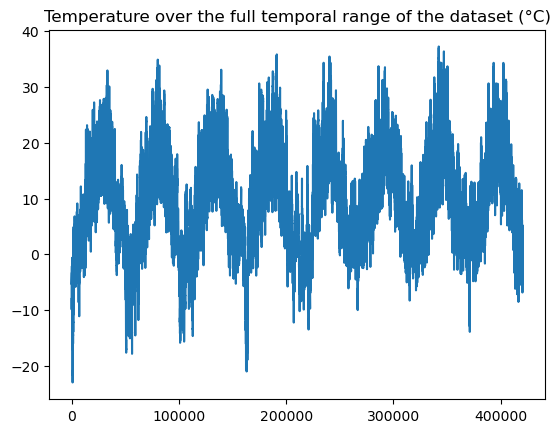

In [3]:
from matplotlib import pyplot as plt
import numpy as np

temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1)) 
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(",")[1:]] 
  temperature[i] = values[1]
  raw_data[i, :] = values[:]

plt.plot(range(len(temperature)), temperature)
plt.title("Temperature over the full temporal range of the dataset (°C)")
plt.show()

Since the data is recorded every 10 minutes, there are 24 × 6 = 144 data points per day. The plot below shows the temperature recordings over the first 10 days of data.

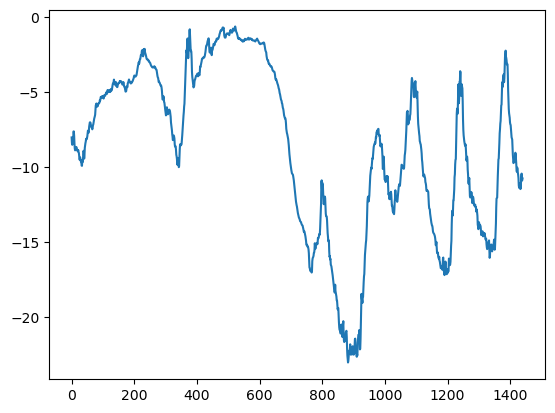

In [4]:
plt.plot(range(1440), temperature[:1440])

From the two plots above, it's clear that the longer term temperature is more predictable as it is clearly periodic. However, the temperature variation on the timeframe of days is much harder to predict, with no stable, discernable pattern.

In all our tests, we’ll use the first 50% of the data for training, the following 25% for validation, and the last 25% for testing.

In [5]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [6]:
# Normalizing the data
mean = raw_data[:num_train_samples].mean(axis=0)
std = raw_data[:num_train_samples].std(axis=0)
raw_data -= mean
raw_data /= std

We’ll use `timeseries_dataset_from_array()` to instantiate three datasets: one for training, one for validation, and one for testing.

In [7]:
import keras

sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
  raw_data[:-delay],
	targets=temperature[delay:], 
	sampling_rate=sampling_rate, 
	sequence_length=sequence_length,
	shuffle=True,
	batch_size=batch_size,
	start_index=0,
	end_index=num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
	raw_data[:-delay],
	targets=temperature[delay:], 
	sampling_rate=sampling_rate, 
	sequence_length=sequence_length,
	shuffle=True,
	batch_size=batch_size,
	start_index=num_train_samples,
	end_index=num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
	raw_data[:-delay],
	targets=temperature[delay:], 
	sampling_rate=sampling_rate, 
	sequence_length=sequence_length,
	shuffle=True,
	batch_size=batch_size, 
	start_index=num_train_samples + num_val_samples
)

2024-05-11 14:42:11.154475: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-11 14:42:13.186058: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Each dataset yields a tuple `(samples, targets)`, where samples is a batch of 256 samples, each containing 120 consecutive hours of input data, and targets is the corresponding array of 256 target temperatures.

# Developing a Baseline (Non-ML) Prediction

Here we consider a far simpler predictive model than any machine learning method. We simply propose a common-sense prediction that the temperature 24 hours from now will be equal to the temperature right now.

We can evaluate this approach, using the mean absolute error (MAE) metric, defined as:

`np.mean(np.abs(preds - targets))`

In [8]:
def evaluate_naive_method(dataset): 
  total_abs_err = 0.
  samples_seen = 0
  for samples, targets in dataset:
      preds = samples[:, -1, 1] * std[1] + mean[1]
      total_abs_err += np.sum(np.abs(preds - targets))
      samples_seen += samples.shape[0]
  return total_abs_err / samples_seen
  
print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


Interpretation: If you always assume that the temperature 24 hours in the future will be the same as it is now, you will be off by 2.5 °C on average.

This isn't bad, but our goal is to use our knowledge of deep learning to do better.

# Trying a Dense NN

Before considering complicated and computationally expensive models such as RNNs, it is worth trying a cheap, small and densely connected neural network first. This is the best way to make sure any further complexity you throw at the problem is legitimate and delivers real benefits.

We use mean squared error (MSE) as the loss funtction, rather than MAE, because unlike MAE, it’s smooth around zero, which is a useful property for gradient descent.

Note the lack of an activation function on the last Dense layer, which is typical for a regression problem.

In [9]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# We use a callback to save the best-performing model (name: "jena_dense.keras")
callbacks = [keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True)]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras") 
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10


819/819 [==============================] - 10s 12ms/step - loss: 13.1312 - mae: 2.7950 - val_loss: 10.9177 - val_mae: 2.6105
Epoch 2/10
819/819 [==============================] - 10s 12ms/step - loss: 9.3201 - mae: 2.4018 - val_loss: 12.6177 - val_mae: 2.8100
Epoch 3/10
819/819 [==============================] - 10s 12ms/step - loss: 8.5384 - mae: 2.2999 - val_loss: 10.0907 - val_mae: 2.5204
Epoch 4/10
819/819 [==============================] - 10s 12ms/step - loss: 8.0606 - mae: 2.2352 - val_loss: 13.0060 - val_mae: 2.8706
Epoch 5/10
819/819 [==============================] - 10s 12ms/step - loss: 7.7328 - mae: 2.1893 - val_loss: 10.8615 - val_mae: 2.6160
Epoch 6/10
819/819 [==============================] - 10s 12ms/step - loss: 7.4767 - mae: 2.1527 - val_loss: 10.7760 - val_mae: 2.5979
Epoch 7/10
819/819 [==============================] - 10s 12ms/step - loss: 7.2589 - mae: 2.1218 - val_loss: 10.1356 - val_mae: 2.5195
Epoch 8/10
819/819 [==============================] - 10s 12ms/st

## Loss Curves

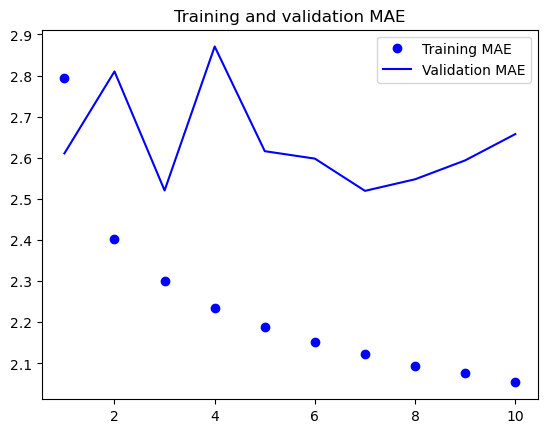

In [10]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"] 
epochs = range(1, len(loss) + 1) 
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

From the plot, we can see that the validation MAE rarely does better than the no-learning baseline we considered previously which had an MAE of 2.5 °C. It is not easy to outperform.

# Applying a 1D Convolutional model

We'll try a 1D convnet on our temperature-forecasting problem. We’ll pick an initial window length of 24, so that we look at 24 hours of data at a time (one cycle).

In [11]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("jena_conv.keras", save_best_only=True)]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)
model = keras.models.load_model("jena_conv.keras") 
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10


819/819 [==============================] - 17s 20ms/step - loss: 21.6439 - mae: 3.6493 - val_loss: 23.1254 - val_mae: 3.8153
Epoch 2/10
819/819 [==============================] - 17s 20ms/step - loss: 14.6315 - mae: 3.0265 - val_loss: 16.2819 - val_mae: 3.1632
Epoch 3/10
819/819 [==============================] - 17s 20ms/step - loss: 13.3843 - mae: 2.8866 - val_loss: 14.3098 - val_mae: 2.9791
Epoch 4/10
819/819 [==============================] - 17s 20ms/step - loss: 12.6035 - mae: 2.8055 - val_loss: 18.1611 - val_mae: 3.4162
Epoch 5/10
819/819 [==============================] - 17s 20ms/step - loss: 11.9949 - mae: 2.7364 - val_loss: 14.8058 - val_mae: 3.0275
Epoch 6/10
819/819 [==============================] - 17s 20ms/step - loss: 11.4712 - mae: 2.6767 - val_loss: 17.4889 - val_mae: 3.2977
Epoch 7/10
819/819 [==============================] - 17s 20ms/step - loss: 11.0576 - mae: 2.6245 - val_loss: 14.1229 - val_mae: 2.9628
Epoch 8/10
819/819 [==============================] - 17s 2

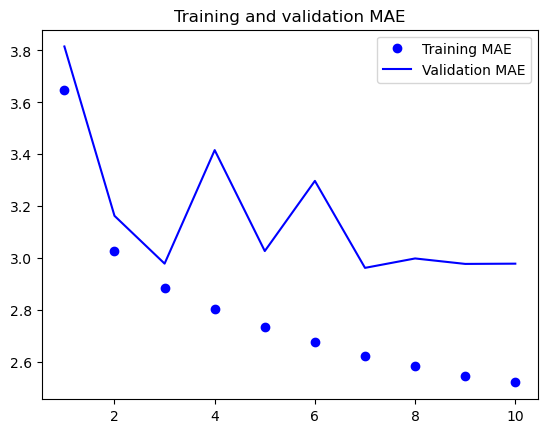

In [12]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

This model performs even worse than the densely connected one, only achieving a validation MAE of about 3.0 degrees, far from the common-sense baseline.

Why does this model not perform well?
  - Weather data doesn’t quite respect the translation invariance assumption. While the data does feature daily cycles, data from a morning follows different properties than data from an evening or from the middle of the night.
  - A 1D convnet is unable to leverage that the order matters significantly in our data. For example, the recent past is far more informative for predicting the next day’s temperature than data from five days ago.

# First RNN

Above we have considered two approaches, neither of which performed especially well compared to our baseline.

1. **Densely connected NN**: A densely connected approach first flattens the timeseries, which removes the notion of time from the input data.
2. **Convolutional NN**: The convolutional approach treats every segment of the data in the same way, even applying pooling, which destroys order information.

Our third approach considers a neural network architectures designed specifically to treat timeseries data as what it is: a sequence, where causality and order matter.

In [13]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True)]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 58s 69ms/step - loss: 46.3309 - mae: 4.9679 - val_loss: 13.5046 - val_mae: 2.7702
Epoch 2/10
819/819 [==============================] - 56s 68ms/step - loss: 11.3243 - mae: 2.6058 - val_loss: 9.4430 - val_mae: 2.3889
Epoch 3/10
819/819 [==============================] - 54s 65ms/step - loss: 9.8542 - mae: 2.4434 - val_loss: 9.5367 - val_mae: 2.3984
Epoch 4/10
819/819 [==============================] - 56s 68ms/step - loss: 9.3585 - mae: 2.3763 - val_loss: 9.6045 - val_mae: 2.3990
Epoch 5/10
819/819 [==============================] - 56s 68ms/step - loss: 8.9060 - mae: 2.3244 - val_loss: 9.7310 - val_mae: 2.4118
Epoch 6/10
819/819 [==============================] - 56s 69ms/step - loss: 8.5592 - mae: 2.2811 - val_loss: 9.7926 - val_mae: 2.4178
Epoch 7/10
819/819 [==============================] - 56s 68ms/step - loss: 8.3107 - mae: 2.2483 - val_loss: 9.9798 - val_mae: 2.4393
Epoch 8/10
819/819 [==============================] - 57s 6

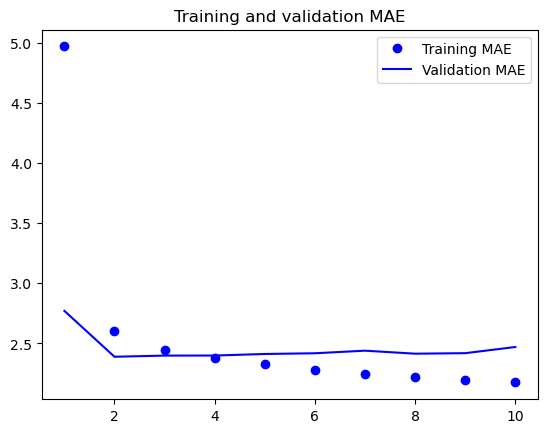

In [14]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Here we see the results are much better. The LSTM achieves a validation MAE as low as 2.36 degrees and a test MAE of 2.59 degrees.

The LSTM-based model can finally beat the common-sense baseline (albeit by a small amount, for now), demonstrating the value of machine learning on this task.

# RNNs: The Vanishing Gradient Problem

In practice, one rarely works with Keras' `SimpleRNN` layer. It’s generally too simplistic to be of real use. In particular, `SimpleRNN` has a major issue: although it should theoretically be able to retain at time $t$ information about inputs seen many timesteps before, such long-term dependencies prove impossible to learn in practice. This is due to the vanishing gradient problem, an effect that is similar to what is observed with non-recurrent networks (feedforward networks) that are many layers deep: as you keep adding layers to a network, the network eventually becomes untrainable.

The other two recurrent NN architectures available in Keras, `LSTM` and `GRU` were specifically designed to address this issue.

# Advanced Techniques for RNNs

In this section we'll cover the following techniques to improve our temperature-forecasting RNN.

* *Recurrent dropout* - This is a variant of dropout, used to fight overfitting in recurrent layers.
* *Stacking recurrent layers* - This increases the representational power of the model (at the cost of higher computational loads).
* *Bidirectional recurrent layers* - These present the same information to a recurrent network in different ways, increasing accuracy and mitigating forgetting issues.

## 1. Using recurrent dropout to combat overfitting

How we know overfitting is a problem in our RNN:
  - Looking at the plot of Training MAE vs. Validation MAE, the training and validation losses start to diverge considerably after a few epochs. This is evidence of overfitting.

In [15]:
import keras

sequence_length = 120

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras", save_best_only=True)]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=25, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/25
531/819 [==================>...........] - ETA: 26s - loss: 35.0254 - mae: 4.3611

819/819 [==============================] - 90s 107ms/step - loss: 28.3761 - mae: 3.9258 - val_loss: 10.0281 - val_mae: 2.4573
Epoch 2/25
819/819 [==============================] - 87s 107ms/step - loss: 14.6776 - mae: 2.9782 - val_loss: 9.1889 - val_mae: 2.3636
Epoch 3/25
819/819 [==============================] - 87s 107ms/step - loss: 13.7132 - mae: 2.8714 - val_loss: 9.8867 - val_mae: 2.4584
Epoch 4/25
819/819 [==============================] - 88s 107ms/step - loss: 12.9687 - mae: 2.7937 - val_loss: 9.8138 - val_mae: 2.4501
Epoch 5/25
819/819 [==============================] - 87s 107ms/step - loss: 12.5670 - mae: 2.7524 - val_loss: 9.5999 - val_mae: 2.4175
Epoch 6/25
819/819 [==============================] - 88s 107ms/step - loss: 12.2628 - mae: 2.7112 - val_loss: 9.2960 - val_mae: 2.3761
Epoch 7/25
819/819 [==============================] - 87s 106ms/step - loss: 11.9792 - mae: 2.6845 - val_loss: 9.0904 - val_mae: 2.3486
Epoch 8/25
819/819 [==============================] - 88s 

In [16]:
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 12s 30ms/step - loss: 11.4835 - mae: 2.6975
Test MAE: 2.70


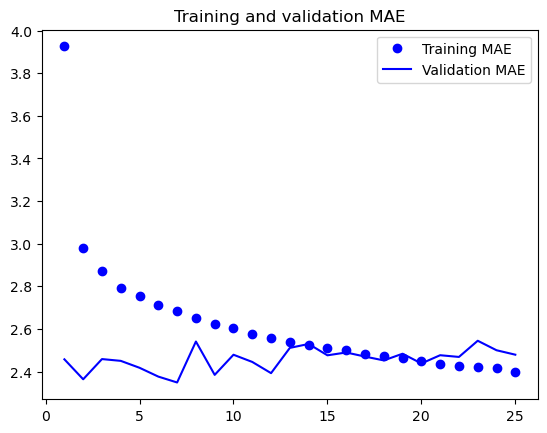

In [17]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

The plot above shows the results of including recurrent dropout: We are no longer overfitting during the first 15 epochs. Furthermore, we achieve a validation MAE as low as 2.27 degrees (7% improvement over the no-learning baseline) and a test MAE of 2.45 degrees (6.5% improvement over the baseline).

## 2. Stacking recurrent layers

This approach should be considered when you’re no longer overfitting but seem to have hit a performance bottleneck.

Below, for variation, we will use GRU layers rather than LSTM.

In [18]:
import keras

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras", save_best_only=True)]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset, epochs=25, validation_data=val_dataset, callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")

Epoch 1/25
819/819 [==============================] - 170s 202ms/step - loss: 24.1094 - mae: 3.6334 - val_loss: 9.5618 - val_mae: 2.3995
Epoch 2/25
819/819 [==============================] - 165s 202ms/step - loss: 14.1312 - mae: 2.9122 - val_loss: 9.1681 - val_mae: 2.3562
Epoch 3/25
819/819 [==============================] - 165s 202ms/step - loss: 13.3815 - mae: 2.8366 - val_loss: 9.5376 - val_mae: 2.4216
Epoch 4/25
819/819 [==============================] - 165s 202ms/step - loss: 12.8934 - mae: 2.7819 - val_loss: 9.3864 - val_mae: 2.3854
Epoch 5/25
819/819 [==============================] - 165s 202ms/step - loss: 12.3247 - mae: 2.7269 - val_loss: 8.8264 - val_mae: 2.3166
Epoch 6/25
819/819 [==============================] - 165s 201ms/step - loss: 11.8404 - mae: 2.6724 - val_loss: 9.0930 - val_mae: 2.3596
Epoch 7/25
819/819 [==============================] - 165s 201ms/step - loss: 11.4522 - mae: 2.6325 - val_loss: 8.7162 - val_mae: 2.3040
Epoch 8/25
819/819 [=====================

In [19]:
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

300/405 [=====================>........] - ETA: 5s - loss: 9.5906 - mae: 2.4314

405/405 [==============================] - 23s 55ms/step - loss: 9.6076 - mae: 2.4338
Test MAE: 2.43


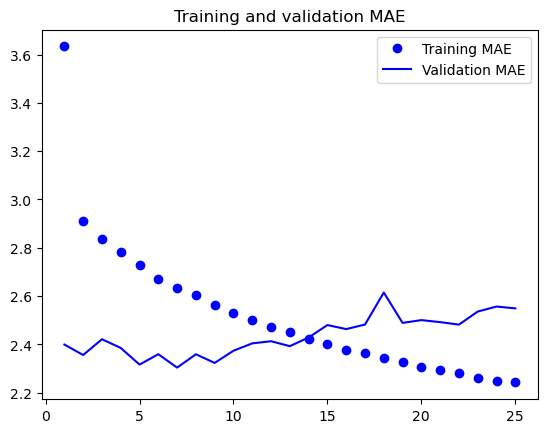

In [20]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## 3. Using bidirectional RNNs

A bidirectional RNN is a common RNN variant that can offer greater performance than a regular RNN on certain tasks. It’s frequently used in natural language processing. A bidirectional RNN exploits the order sensitivity of RNNs: it uses two regular RNNs, such as the GRU and LSTM layers you’re already familiar with, each of which processes the input sequence in one direction (chronologically and antichronologically), and then merges their representations. By processing a sequence both ways, a bidirectional RNN can catch patterns that may be overlooked by a unidi- rectional RNN.

`Bidirectional` creates a second, separate instance of this recurrent layer and uses one instance for processing the input sequences in chronological order and the other instance for processing the input sequences in reversed order.

In [21]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
171/819 [=====>........................] - ETA: 42s - loss: 77.0204 - mae: 6.8182

819/819 [==============================] - 70s 82ms/step - loss: 28.5334 - mae: 3.8098 - val_loss: 10.5604 - val_mae: 2.5151
Epoch 2/10
819/819 [==============================] - 66s 80ms/step - loss: 9.6280 - mae: 2.4205 - val_loss: 9.8052 - val_mae: 2.4301
Epoch 3/10
819/819 [==============================] - 66s 80ms/step - loss: 8.6891 - mae: 2.2952 - val_loss: 9.9177 - val_mae: 2.4444
Epoch 4/10
819/819 [==============================] - 65s 79ms/step - loss: 8.1454 - mae: 2.2236 - val_loss: 10.1893 - val_mae: 2.4846
Epoch 5/10
819/819 [==============================] - 66s 81ms/step - loss: 7.6477 - mae: 2.1536 - val_loss: 10.3819 - val_mae: 2.5132
Epoch 6/10
819/819 [==============================] - 66s 81ms/step - loss: 7.2101 - mae: 2.0894 - val_loss: 10.5852 - val_mae: 2.5327
Epoch 7/10
819/819 [==============================] - 66s 81ms/step - loss: 6.8732 - mae: 2.0394 - val_loss: 10.7372 - val_mae: 2.5504
Epoch 8/10
819/819 [==============================] - 66s 81ms/step

While the code above does represent an implementation of a bidirectional RNN - in this case it does not improve the predictive power of our model. This is because the temperature data depends heavily on it's recently-previous values. As such, the antichronological half of the model performs poorly, and the model must rely on the chronological half for predictive power. At the same time, the antichronological half doules the network's capacity and causes it to start overfitting much earlier in the training process. 

Bidirectional RNNs do however prove much more successful in predicting other types of sequences - text data for example, where order matters, yet where *which order* you use doesn’t matter. For a while in 2016, bidirectional LSTMs were considered the state of the art on many natural language processing tasks.

In [22]:
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

  1/405 [..............................] - ETA: 48s - loss: 13.2987 - mae: 2.8196

405/405 [==============================] - 12s 30ms/step - loss: 12.4215 - mae: 2.7919
Test MAE: 2.79


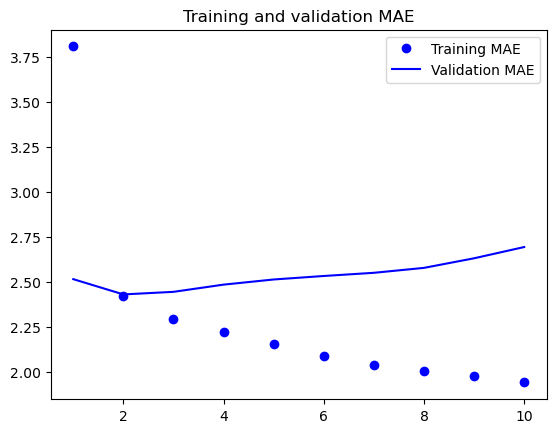

In [23]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()